# Holland & Powell 2011 Standard State Code Generator 
Required system packages and initialization

In [29]:
import pandas as pd
import numpy as np
import sympy as sym
sym.init_printing()

Required ENKI packages

In [30]:
from thermoengine import coder

# Types of terms in a standard state properties description
There are three classes of terms:
1. Terms that apply over the whole of $T$-, $P$-space, $T_r \le T$, $P_r \le P$
2. Terms that apply over a specified range of $T$-, $P$-space, $(T_{r_\lambda},P_{r_\lambda}) \le (T,P) \le (T_\lambda,P_\lambda)$
3. Terms that apply to a specific $T_t$ and $P_t$ and higher $T$, $P$, $T_t \le T$, $P_t \le P$

Second-order phase transitions ($lambda$-transitions) are an example of the second type, as are order disorder transformations. First-order phase transitions are an example of the third type.  

## Create a model class for the Gibbs free energy

In [31]:
model = coder.StdStateModel()

Retrieve sympy symbols for model variables and reference conditions

In [32]:
T = model.get_symbol_for_t()
P = model.get_symbol_for_p()
Tr = model.get_symbol_for_tr()
Pr = model.get_symbol_for_pr()

### Define model expressions applicable over all of T,P space
An expression for the Gibbs free energy, $G(T,P)$ or the Helmholtz energy $A(T,V)$ is constructed.  The expression may have multiple parts.  Often the heat capacity function is postulated, then integrated to yield expressions for the entahlpy, entropy, and in combination the energy potential. Then, an equation of state (EOS) is adopted and that term is integrated in pressure or volume and added to the heat capacity integrals. This proceedure is follwed here.
#### (1) $C_P$ integrals
The isobaric heat capacity terms parameterized as: $C_P =  $,
and in addition the reference condition third law entropy, $ S_{Tr,Pr} $, and enthalpy of formation from the
elements, $ \Delta H_{Tr,Pr} $, constitute additional parameters:

* NOTE this does not include critical heat capacity contribution

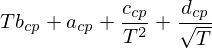

In [33]:
a_cp,b_cp,c_cp,d_cp= sym.symbols('a_cp b_cp c_cp d_cp')
S_max = sym.symbols('S_max')
CpPr = a_cp+b_cp*T+c_cp/T**2+d_cp/sym.sqrt(T)
STrPr,HTrPr = sym.symbols('S_TrPr H_TrPr')
CpPr

In [34]:

# Tc = sym.symbols('Tc')
# Cp_c = S_max*T/2/sym.sqrt(Tc)/sym.sqrt(T-Tc)
# Cp_c = sym.Piecewise((S_max*T/2/sym.sqrt(Tc)/sym.sqrt(T-Tc), T<Tc), (0,T>=Tc))
# Cp_c

Specify parameters ...

In [35]:
params = [('H_TrPr','J',HTrPr), ('S_TrPr','J/K',STrPr), ('a_cp','J/K-m',a_cp),('b_cp','J/K^2-m',b_cp),
          ('c_cp','J-K/m',c_cp), ('d_cp','J-K^(1/2)/m',d_cp)]

Define the heat capacity contribution to the Gibbs free energy ...

In [36]:
GPr = HTrPr + sym.integrate(CpPr,(T,Tr,T)) - T*(STrPr + sym.integrate(CpPr/T,(T,Tr,T)))

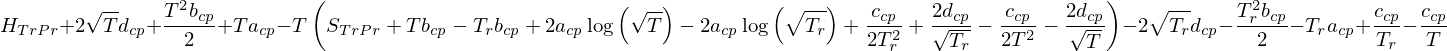

In [37]:
GPr

... and add this expression to the model

In [38]:
model.add_expression_to_model(GPr, params)

#### (2) $V$ (EOS) integrals
Next, define a volume-explicit equation of state applicable over the whole of temperature and pressure space

In [39]:

VTrPr,a0,K0,K_P,K_P2 = sym.symbols('V_TrPr a0 K0 K_P K_P2')
a_v,b_v,c_v = sym.symbols('a_v b_v c_v')

Pth = sym.symbols('P_th')
# V_T, K_T, dK_T, dK_P = sym.symbols("V_T K_T K'_T K'_P")
# dK_P 

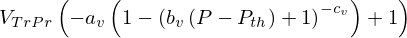

In [40]:
V = VTrPr*( 1 - a_v*(1-(1+b_v*(P-Pth))**(-c_v)) )
V

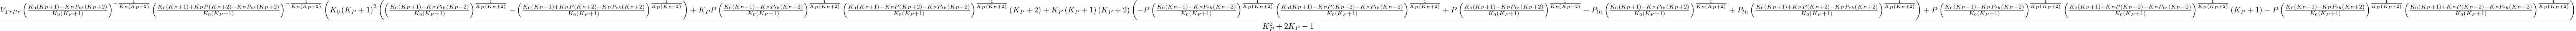

In [41]:
VdP = sym.integrate(V, (P, 0, P), conds='none')
VdP = VdP.simplify()

VdP = VdP.subs(a_v, (1+K_P)/(1+K_P+K0*K_P2))
VdP = VdP.subs(b_v, K_P/K0 - K_P2/(1+K_P))
VdP = VdP.subs(c_v, (1+K_P+K0*K_P2)/(K_P**2 +K_P - K0*K_P2))
VdP = VdP.subs(K_P2, -K_P/K0)
VdP.simplify()

In [42]:

# V = VTrPr*(-K_P +(1+K_P)*(1+K_P/K0*(2+K_P)/(1+K_P)*(P-Pth))**(-1/K_P/(2+K_P)))  
# V

In [43]:
# VdP_HP = P*VTrPr*(1-a_v + a_v*((1-b_v*Pth)**(1-c_v) - (1+b_v*(P-Pth))**(1-c_v))/(b_v*(c_v-1)*P) )
# VdP_HP = VdP_HP.simplify()
# VdP_HP = VdP_HP.subs(a_v, (1+K_P)/(1+K_P+K0*K_P2))
# VdP_HP = VdP_HP.subs(b_v, K_P/K0 - K_P2/(1+K_P))
# VdP_HP = VdP_HP.subs(c_v, (1+K_P+K0*K_P2)/(K_P**2 +K_P - K0*K_P2))
# VdP_HP = VdP_HP.subs(K_P2, -K_P/K0)
# VdP_HP.simplify()


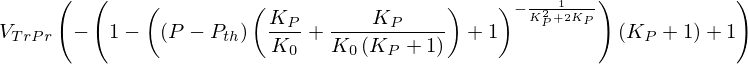

In [44]:
V = V.subs(a_v, (1+K_P)/(1+K_P+K0*K_P2))
V = V.subs(b_v, K_P/K0 - K_P2/(1+K_P))
V = V.subs(c_v, (1+K_P+K0*K_P2)/(K_P**2 +K_P - K0*K_P2))
V = V.subs(K_P2, -K_P/K0)
V

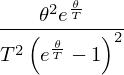

In [45]:
theta, n = sym.symbols('theta n')
alphaK = (theta/T)**2*sym.exp(theta/T)/(sym.exp(theta/T)-1)**2
alphaK



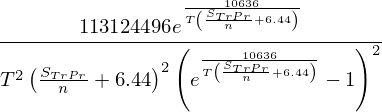

In [46]:
theta_expr = 10636/(STrPr/n +6.44)
alphaK = alphaK.subs(theta, theta_expr)
alphaK

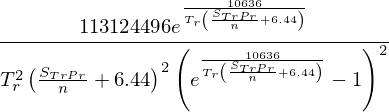

In [47]:
alphaK0 = alphaK.subs(T,Tr)
alphaK0

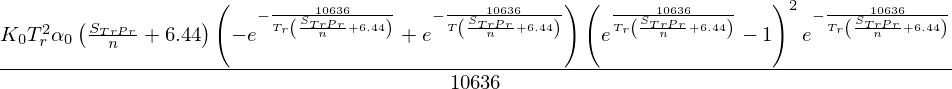

In [48]:

alpha0 = sym.symbols('alpha0')

Pth_expr = alpha0*K0*theta/alphaK0*(1/(sym.exp(theta/T)) -1/(sym.exp(theta/Tr)))
Pth_expr = Pth_expr.subs(theta, theta_expr)
Pth_expr

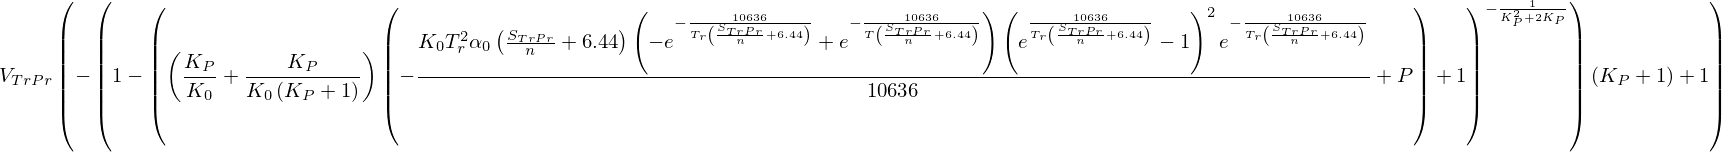

In [49]:
V = V.subs(Pth, Pth_expr)
V

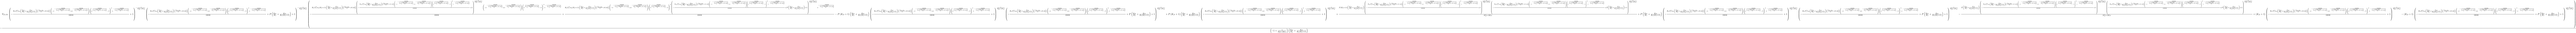

In [50]:
VdP = VdP.subs(Pth, Pth_expr)
VdP

In [51]:
VdP.free_symbols

In [52]:
# params= [('V_TrPr', 'J/bar-m', VTrPr), ('a0','1/K',a0),  ('K0','bar',K0), ('dKdT','1/K',dK_T)]
params= [('V_TrPr', 'J/bar-m', VTrPr), ('S_TrPr', 'J/K-m', STrPr), 
         ('alpha0','1/K',alpha0),  ('n','',n), ('K0','bar',K0),  ('K_P','',K_P)]

In [53]:
model.add_expression_to_model(VdP, params)